# New Mexico Lakes and Reservoirs Water levels
> This notebook scrapes the water level data at ZUNI SALT LAKE NR QUEMADO, NM. 
- toc: true
- branch: master
- comments: true
- author: a
- categories: [web scraping]

# About 
I heard New Mexico going through drought from  NM residents and wanted to explore the available water data to confirm if the data supports what residents were saying. I hope this notebook serves as starting point to all the researchers to analyze the lake and reseviour situation at New Mexico. 
This notebook scrapes data for one of the lake listed at [USGS ](https://waterdata.usgs.gov/nm/nwis/current/?type=lake&group_key=county_cd) website

In [1]:

#collapse-show
import pandas as pd
import requests
from bs4 import BeautifulSoup



# Extracting the data from source
## Scraping the data and writing to a file
The website provides simple url with some parameters as argument to get the data. They also provide the tab seperated data which makes extracting data easier as compared to parsing html files.

In [2]:
# site number data url
file_name = 'zuni_salt_lake.csv'
site_id = '09386189'
start_date = '2020-04-03'
end_date = '2021-04-03'

site_data_url = f"https://waterdata.usgs.gov/nm/nwis/dv?cb_00010=on&cb_00045=on&cb_62615=on&format=rdb&site_no={site_id}&referred_module=sw&period=&begin_date={start_date}&end_date={end_date}"

print(f"Requesting {site_data_url}...")
response = requests.get(site_data_url)
with open(file_name, 'wb') as file_writer:
    file_writer.write(response.content)

print(f"Writing data to {file_name}...")


Requesting https://waterdata.usgs.gov/nm/nwis/dv?cb_00010=on&cb_00045=on&cb_62615=on&format=rdb&site_no=09386189&referred_module=sw&period=&begin_date=2020-04-03&end_date=2021-04-03...
Writing data to zuni_salt_lake.csv...


## Loading Raw Data
Skipping the rows that has bad data and mapping information

In [3]:

df = pd.read_csv(file_name, sep='\t', skiprows= 31)
df = df.iloc[1:]
df.head()


,agency_cd,site_no,datetime,254000_00010_00003,254000_00010_00003_cd,259996_00045_00006,259996_00045_00006_cd,277766_62615_32400,277766_62615_32400_cd
1,USGS,09386189,2020-04-03,14.1,A,0.00,P,6222.11,P
2,USGS,09386189,2020-04-04,14.8,A,0.00,P,6222.12,P
3,USGS,09386189,2020-04-05,15.4,A,0.00,P,6222.10,P
4,USGS,09386189,2020-04-06,15.9,A,0.00,P,6222.10,P
5,USGS,09386189,2020-04-07,16.8,A,0.00,P,6222.10,P


# Transforming Data
## Mapping system headers to text

Some of the column headers are system codes and he first few lines of the csv file gives the information about the mapping for the headers,like: 

Data Mapping for site 09386189 is as below:

|            TS   | parameter  | statistic    | Description |
| :-------------- | :--------: | :----------: | -----------: |
|        254000   |    00010  |   00003    | Temperature, water, degrees Celsius (Mean) |
|        259996   |    00045  |   00006    | Precipitation, total, inches (Sum) |
|        277766   |    62615  |   32400    | Lake or reservoir water surface elevation above NAVD 1988, feet (Observation at midnight) |
   
     A:  Approved for publication -- Processing and review completed.
     P:  Provisional data subject to revision.
     e:  Value has been estimated.


Let's map the headers to the description. 





In [4]:
headers = { 
     '254000_00010_00003' : 'Temperature',
    '259996_00045_00006': 'Precipitation', 
    '277766_62615_32400':'Elevation'
}

headers.update({f"{k}_cd": f"{v}_qualification_code" for k,v in headers.items()})
df.columns = [headers.get(val,val) for val in df.columns ]
df = df.astype({'Temperature': float, 'Precipitation': float, 'Elevation': float })
units = {"Temperature": 'Temperature, water, degrees Celsius (Mean)', 'Precipitation':'Precipitation, total, inches (Sum)', 'Elevation':'water surface elevation above NAVD 1988, feet (Observation at midnight)'}
df.head()


,agency_cd,site_no,datetime,Temperature,Temperature_qualification_code,Precipitation,Precipitation_qualification_code,Elevation,Elevation_qualification_code
1,USGS,09386189,2020-04-03,14.1,A,0.0,P,6222.11,P
2,USGS,09386189,2020-04-04,14.8,A,0.0,P,6222.12,P
3,USGS,09386189,2020-04-05,15.4,A,0.0,P,6222.10,P
4,USGS,09386189,2020-04-06,15.9,A,0.0,P,6222.10,P
5,USGS,09386189,2020-04-07,16.8,A,0.0,P,6222.10,P


In [5]:
print(f"the shape of dataframe is : {df.shape}")
df.describe()

the shape of dataframe is : (366, 9)


,Temperature,Precipitation,Elevation
count,355.000000,363.000000,366.000000
mean,14.875211,0.010744,6221.517268
std,6.706954,0.045823,0.256291
min,1.700000,0.000000,6221.140000
25%,9.050000,0.000000,6221.310000
50%,16.000000,0.000000,6221.500000
75%,20.750000,0.000000,6221.710000
max,27.400000,0.380000,6222.130000


### Missing Data
Note that there are few missing values on Temperature and Precipitation column. These null values should be treated if these dataset is being used to build the model. Temperature can be replaced with the 5 days rolling average and the precipitation can be set to zero because there are lot of points where the precipitation is zero.

# Plotting Data
The features `Temperature` , `Precipitation` and `Elevation` are associated with time stamp which makes them timeseries data. Let's plot these timeseries data as see if there is any pattern. 

<AxesSubplot:xlabel='datetime'>

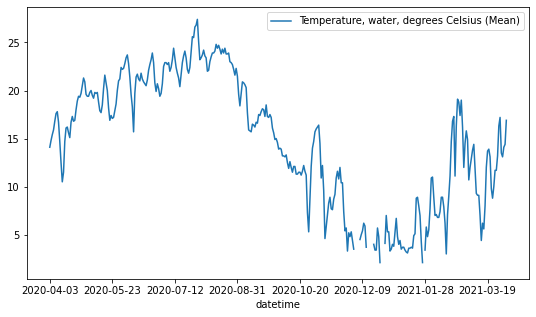

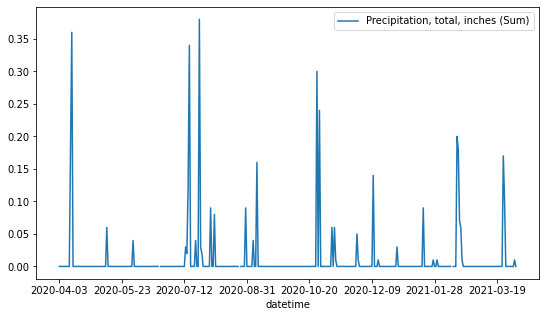

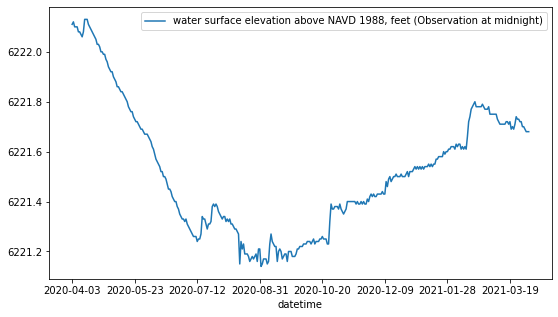

In [6]:
# Vizualizing the data 
df.plot(x='datetime', y='Temperature', label=units['Temperature'],figsize = (9,5))
df.plot(x='datetime', y='Precipitation', label=units['Precipitation'],figsize = (9,5))
df.plot(x='datetime', y='Elevation', label=units['Elevation'],figsize = (9,5))
